In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import os
import gc
import re
import distance

from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

from wordcloud import WordCloud, STOPWORDS


from sklearn.metrics import accuracy_score,log_loss,roc_auc_score,classification_report
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from scipy.spatial.distance import cosine, cityblock, jaccard, canberra, euclidean, minkowski, braycurtis

import scipy
import xgboost as xgb
from fuzzywuzzy import fuzz

from sklearn.manifold import TSNE
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDClassifier

from collections import Counter
from sklearn.metrics import confusion_matrix
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold 
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

D:\Anaconda\Lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [19]:
import gensim
import smart_open
from gensim.models import Word2Vec
from scipy.spatial.distance import cosine, cityblock, jaccard, canberra, euclidean, minkowski, braycurtis

from tqdm import tqdm_notebook

In [2]:
df= pd.read_csv("train.csv") 
df['question1'] = df['question1'].apply(lambda x: str(x)) 
df['question2'] = df['question2'].apply(lambda x: str(x)) 
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [3]:
df = df.dropna(how="any").reset_index(drop=True)
df.shape



(404290, 6)

<Axes: xlabel='is_duplicate'>

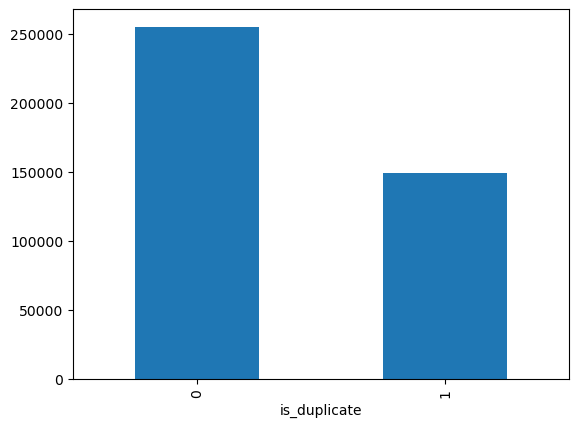

In [4]:
df.groupby('is_duplicate')['id'].count().plot.bar()

In [5]:
df['is_duplicate'].value_counts(normalize = True)

is_duplicate
0    0.630802
1    0.369198
Name: proportion, dtype: float64

### About Similar question pair - 36.92% from the dataset

### Non-Similar question pair - 63.07% from the dataset

In [6]:
#Number of Unique Questions

qids = pd.Series(df['qid1'].tolist() + df['qid2'].tolist())
unique_qids = len(np.unique(qids))
qs_morethan_onetime = np.sum(qids.value_counts() > 1)

print ('Total Unique Questions: {}\n'.format(unique_qids))

print ('Number of unique questions repeating more than once: {} ({}%)\n'.format(qs_morethan_onetime,qs_morethan_onetime/unique_qids*100))

print ('Max number of times a single question is repeated: {}\n'.format(max(qids.value_counts())))

Total Unique Questions: 537933

Number of unique questions repeating more than once: 111780 (20.77953945937505%)

Max number of times a single question is repeated: 157



D:\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
D:\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
D:\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
D:\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


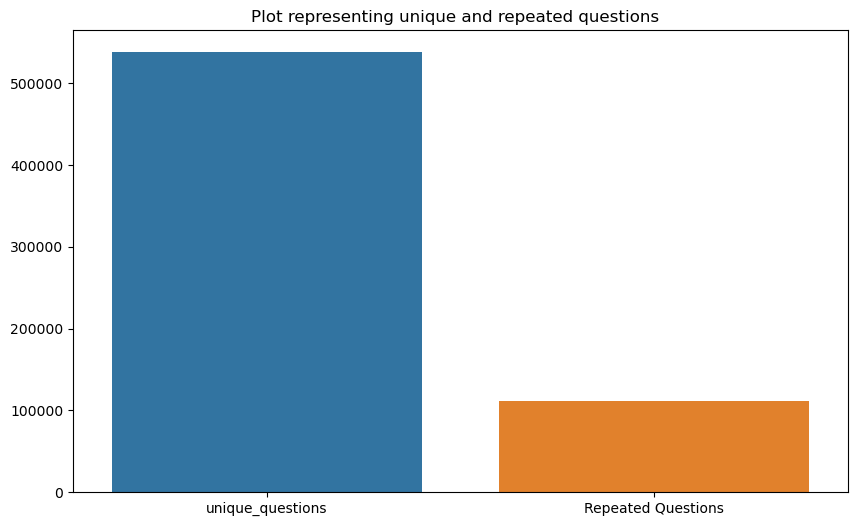

In [7]:
x = ["unique_questions" , "Repeated Questions"]
y =  [unique_qids , qs_morethan_onetime]

plt.figure(figsize=(10, 6))
plt.title ("Plot representing unique and repeated questions  ")
sns.barplot(x=x,y=y)
plt.show()

In [8]:
# duplicate questions check

pair_duplicates = df[['qid1','qid2','is_duplicate']].groupby(['qid1','qid2']).count().reset_index()

print ("Number of duplicate questions",(pair_duplicates).shape[0] - df.shape[0])

Number of duplicate questions 0


In [9]:
# checking rows with NaN(Null) values

nan_rows = df[df.isnull().any(axis=1)]
print(nan_rows)


Empty DataFrame
Columns: [id, qid1, qid2, question1, question2, is_duplicate]
Index: []


### Data Cleaning and Stopwords removal

In [10]:
SPECIAL_TOKENS = {
    'quoted': 'quoted_item',
    'non-ascii': 'non_ascii_word',
    'undefined': 'something'
}

from string import punctuation
stop_words = stopwords.words('english')

def preprocess(text, stem_words=True):

    
    if pd.isnull(text):
        return ''

    if type(text) != str or text=='':
        return ''
    ps = PorterStemmer()
    
    text = re.sub("\'s", " ", text) 
    text = re.sub(" whats ", " what is ", text, flags=re.IGNORECASE)
    text = re.sub("\'ve", " have ", text)
    text = re.sub("can't", "can not", text)
    text = re.sub("n't", " not ", text)
    text = re.sub("i'm", "i am", text, flags=re.IGNORECASE)
    text = re.sub("\'re", " are ", text)
    text = re.sub("\'d", " would ", text)
    text = re.sub("\'ll", " will ", text)
    text = re.sub("e\.g\.", " eg ", text, flags=re.IGNORECASE)
    text = re.sub("b\.g\.", " bg ", text, flags=re.IGNORECASE)
    text = re.sub("(\d+)(kK)", " \g<1>000 ", text)
    text = re.sub("e-mail", " email ", text, flags=re.IGNORECASE)
    text = re.sub("(the[\s]+|The[\s]+)?U\.S\.A\.", " America ", text, flags=re.IGNORECASE)
    text = re.sub("(the[\s]+|The[\s]+)?United State(s)?", " America ", text, flags=re.IGNORECASE)
    text = re.sub("\(s\)", " ", text, flags=re.IGNORECASE)
    text = re.sub("[c-fC-F]\:\/", " disk ", text)
    
    # remove comma between numbers, i.e. 15,000 -> 15000
    
    text = re.sub('(?<=[0-9])\,(?=[0-9])', "", text)
    text = re.sub('\$', " dollar ", text)
    text = re.sub('\%', " percent ", text)
    text = re.sub('\&', " and ", text)
    
       # Return a list of words
    text = ' '.join([word for word in text.split(" ") if word not in stop_words]).lower()
    #text = ' '.join([ps.stem(word) for word in text])
    return text


In [11]:
df['question1'] = df['question1'].apply(preprocess)
df['question2'] = df['question2'].apply(preprocess)


In [12]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,what step step guide invest share market india?,what step step guide invest share market?,0
1,1,3,4,what story kohinoor (koh-i-noor) diamond?,what would happen indian government stole kohi...,0
2,2,5,6,how i increase speed internet connection using...,how internet speed increased hacking dns?,0
3,3,7,8,why i mentally lonely? how i solve it?,find remainder [math]23^{24}[/math] divided 2423?,0
4,4,9,10,"which one dissolve water quikly sugar, salt, m...",which fish would survive salt water?,0


### Tokenization using pre-trained models/techniques

In [16]:
model = gensim.models.KeyedVectors.load_word2vec_format('./GoogleNews-vectors-negative300.bin', binary=True)


In [20]:
def sent2vec(s):
    words = str(s).lower() #lower the sentence
    words = word_tokenize(words) #tokenize the sentence
    words = [w for w in words if not w in stop_words] #Filter out the stop words
    words = [w for w in words if w.isalpha()] #Filter out non-alpha characters
    M = []
    for w in words:#loop through each word in the sentence
        try:
            M.append(model[w])#Gensim model converts each word in the sentence to a 300-dim vector space and appends to a list.
        except:
            continue
    M = np.array(M) #convert the list to array. Shape = (num_of_words_in_sentence,300)
    v = M.sum(axis=0) #Sum up along the num_of_words_in_sentence through 300-dim. Shape = (1,300) 
    return v / np.sqrt((v ** 2).sum()) #normalize the values with the sum


In [21]:

question1_vectors = np.zeros((df.shape[0], 300)) #vector matrix of shape = (num_of_rows,300) for question 1
for i, q in enumerate(tqdm_notebook(df.question1.values)):
    question1_vectors[i, :] = sent2vec(q) #function call for each question 1
    
question2_vectors  = np.zeros((df.shape[0], 300)) #vector matrix of shape = (num_of_rows,300) for question 2
for i, q in enumerate(tqdm_notebook(df.question2.values)):
    question2_vectors[i, :] = sent2vec(q) #function call for each question 2

C:\Users\Akhil\AppData\Local\Temp\ipykernel_6412\153115473.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i, q in enumerate(tqdm_notebook(df.question1.values)):


  0%|          | 0/404290 [00:00<?, ?it/s]

C:\Users\Akhil\AppData\Local\Temp\ipykernel_6412\502398111.py:14: RuntimeWarning: invalid value encountered in scalar divide
  return v / np.sqrt((v ** 2).sum()) #normalize the values with the sum
C:\Users\Akhil\AppData\Local\Temp\ipykernel_6412\153115473.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i, q in enumerate(tqdm_notebook(df.question2.values)):


  0%|          | 0/404290 [00:00<?, ?it/s]

### taking Necessary Ratios and values to train the learning model

In [22]:
df['len_q1'] = df.question1.apply(lambda x: len(str(x)))
df['len_q2'] = df.question2.apply(lambda x: len(str(x)))
df['common_words'] = df.apply(lambda x: len(set(str(x['question1']).lower().split()).intersection(set(str(x['question2']).lower().split()))), axis=1)


In [23]:
df['fuzz_ratio'] = df.apply(lambda x: fuzz.ratio(str(x['question1']), str(x['question2'])), axis=1)
df['fuzz_partial_ratio'] = df.apply(lambda x: fuzz.partial_ratio(str(x['question1']), str(x['question2'])), axis=1)
df['fuzz_partial_token_set_ratio'] = df.apply(lambda x: fuzz.partial_token_set_ratio(str(x['question1']), str(x['question2'])), axis=1)
df['fuzz_partial_token_sort_ratio'] = df.apply(lambda x: fuzz.partial_token_sort_ratio(str(x['question1']), str(x['question2'])), axis=1)


In [24]:
df['fuzz_token_set_ratio'] = df.apply(lambda x: fuzz.token_set_ratio(str(x['question1']), str(x['question2'])), axis=1)
df['fuzz_token_sort_ratio'] = df.apply(lambda x: fuzz.token_sort_ratio(str(x['question1']), str(x['question2'])), axis=1)


In [25]:
df['cosine_distance'] = [cosine(x, y) for (x, y) in zip(np.nan_to_num(question1_vectors), np.nan_to_num(question2_vectors))]
df['cityblock_distance'] = [cityblock(x, y) for (x, y) in zip(np.nan_to_num(question1_vectors), np.nan_to_num(question2_vectors))]
df['jaccard_distance'] = [jaccard(x, y) for (x, y) in zip(np.nan_to_num(question1_vectors), np.nan_to_num(question2_vectors))]


D:\Anaconda\Lib\site-packages\scipy\spatial\distance.py:622: RuntimeWarning: invalid value encountered in scalar divide
  dist = 1.0 - uv / np.sqrt(uu * vv)


In [26]:
df['canberra_distance'] = [canberra(x, y) for (x, y) in zip(np.nan_to_num(question1_vectors), np.nan_to_num(question2_vectors))]
df['euclidean_distance'] = [euclidean(x, y) for (x, y) in zip(np.nan_to_num(question1_vectors), np.nan_to_num(question2_vectors))]
df['minkowski_distance'] = [minkowski(x, y, 3) for (x, y) in zip(np.nan_to_num(question1_vectors), np.nan_to_num(question2_vectors))]
df['braycurtis_distance'] = [braycurtis(x, y) for (x, y) in zip(np.nan_to_num(question1_vectors), np.nan_to_num(question2_vectors))]

D:\Anaconda\Lib\site-packages\scipy\spatial\distance.py:1157: RuntimeWarning: invalid value encountered in scalar divide
  return l1_diff.sum() / l1_sum.sum()


In [27]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate,len_q1,len_q2,common_words,fuzz_ratio,...,fuzz_partial_token_sort_ratio,fuzz_token_set_ratio,fuzz_token_sort_ratio,cosine_distance,cityblock_distance,jaccard_distance,canberra_distance,euclidean_distance,minkowski_distance,braycurtis_distance
0,0,1,2,what step step guide invest share market india?,what step step guide invest share market?,0,47,41,5,93,...,92,100,93,0.068972,5.081614,1.0,94.023324,0.371408,0.168999,0.186557
1,1,3,4,what story kohinoor (koh-i-noor) diamond?,what would happen indian government stole kohi...,0,41,77,3,66,...,82,91,64,0.512164,14.195119,1.0,177.588090,1.012091,0.455910,0.592655
2,2,5,6,how i increase speed internet connection using...,how internet speed increased hacking dns?,0,51,41,3,48,...,80,67,67,0.222009,9.055989,1.0,135.988707,0.666346,0.307828,0.342306
3,3,7,8,why i mentally lonely? how i solve it?,find remainder [math]23^{24}[/math] divided 2423?,0,38,49,0,11,...,29,28,25,0.650411,15.987437,1.0,192.237828,1.140536,0.506028,0.692421
4,4,9,10,"which one dissolve water quikly sugar, salt, m...",which fish would survive salt water?,0,69,36,1,34,...,71,63,48,0.369993,12.103178,1.0,161.408435,0.860225,0.382770,0.480633


In [28]:
df.to_csv('final_features.csv')